In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import MetaTrader5 as mt5
# import pytz module for working with time zone
import pytz, os
import numpy as np

# Load env variables
%load_ext dotenv
%dotenv

from stockstats import StockDataFrame

# finRL
from finrl.meta.data_processors.processor_alpaca_2 import AlpacaProcessor2
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import REST, TimeFrame


# display data on the MetaTrader 5 package
print("MetaTrader5 package author: ",mt5.__author__)
print("MetaTrader5 package version: ",mt5.__version__)

# Plot with matplotlib
%matplotlib inline

MetaTrader5 package author:  MetaQuotes Ltd.
MetaTrader5 package version:  5.0.37


In [2]:
# establish connection to the MetaTrader 5 terminal
if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    quit()
 
# display data on MetaTrader 5 version
print(mt5.version())

(500, 3391, '05 Aug 2022')


In [3]:
# MT5 account infor
MT5_ACCOUNT = os.environ.get('MT5_ACCOUNT')
MT5_PASSWORD = os.environ.get('MT5_PASSWORD')
MT5_SERVER = os.environ.get('MT5_SERVER')

# Alpaca
API_KEY = os.environ.get('API_KEY')
API_SECRET = os.environ.get('API_SECRET')
API_BASE_URL = os.environ.get('API_BASE_URL')
data_url = os.environ.get('data_url')
TIME_INTERVAL_RAW = '1Day'

# Tick info
TICK_START_DATE='2022-07-01'
TICK_END_DATE='2022-07-31'


TIME_INTERVAL = {
    '1Day': mt5.TIMEFRAME_D1,
    '4Hour': mt5.TIMEFRAME_H4,
    '1Hour': mt5.TIMEFRAME_H1,
    '30Min': mt5.TIMEFRAME_M30,
    '15Min': mt5.TIMEFRAME_M15,
    '5Min': mt5.TIMEFRAME_M5,
    '1Min': mt5.TIMEFRAME_M1,
}

tech_indicator_list=[
    "macd",
    "boll_ub",
    "boll_lb",
    "rsi_30",
    "dx_30",
    "close_14_sma", 
    "close_50_sma",
    "close_200_sma",
    "volume_14_sma",
    "volume_xu_volume_14_sma"
]

# TODO: Add XAuUSD' back. It has different length of rows
TIC_LIST = ['EURUSD', 'USDCHF', 'CADCHF']

# MT5 server time: Europe/Moscow  (GMT+3)


## Alpaca

In [4]:
try:
    alpaca_api = tradeapi.REST(API_KEY, API_SECRET, API_BASE_URL, "v2")
except BaseException:
    raise ValueError("Wrong Account Info!")

## MT5

In [5]:
# now connect to another trading account specifying the password
authorized=mt5.login(login=MT5_ACCOUNT, password=MT5_PASSWORD, server=MT5_SERVER)
if authorized:
    # display trading account data 'as is'
    print(mt5.account_info())
    # display trading account data in the form of a list
    print("Show account_info()._asdict():")
    account_info_dict = mt5.account_info()._asdict()
    for prop in account_info_dict:
        print("  {}={}".format(prop, account_info_dict[prop]))
else:
    print("failed to connect at account #{}, error code: {}".format(MT5_ACCOUNT, mt5.last_error()))

failed to connect at account #6106603, error code: (-2, 'Invalid "login" argument')


In [6]:
def fetch_bars(tic_list: [str]) -> pd.DataFrame:
    
    tic_frames = pd.DataFrame()
    
    for tic in tic_list:
        
        # Fetch the bars from MT5
        tic_rates = mt5.copy_rates_range(
                        tic, 
                        TIME_INTERVAL[TIME_INTERVAL_RAW], 
                        datetime.strptime(TICK_START_DATE, '%Y-%m-%d'), 
                        datetime.strptime(TICK_END_DATE, '%Y-%m-%d')
                    )
        bar_frame = pd.DataFrame(tic_rates) 
        
        # Convert timestamp to datetime
        bar_frame['time'] = pd.to_datetime(bar_frame['time'], unit='s')
        
        # Add tick name
        bar_frame['tic'] = tic
        
        # Rename tick_volume to volume
        bar_frame = bar_frame.rename(columns={"time": "date", "tick_volume": "volume"}, errors="raise")
        
        # Drop column "real_volume"
        bar_frame = bar_frame.drop(columns=['real_volume'])
                
        # Concat bars to the main dataframe
        tic_frames = pd.concat([tic_frames, bar_frame])
        
    return tic_frames

In [7]:
tic_frames = fetch_bars(TIC_LIST)
tic_frames 

,date,open,high,low,close,volume,spread,tic
0,2022-07-04,1.04195,1.04622,1.04163,1.04222,93047,10,EURUSD
1,2022-07-05,1.04199,1.04483,1.02346,1.02643,168007,10,EURUSD
2,2022-07-06,1.02641,1.02761,1.01608,1.01842,186102,10,EURUSD
3,2022-07-07,1.01805,1.02206,1.01436,1.01604,146191,10,EURUSD
4,2022-07-08,1.01589,1.01909,1.00711,1.01844,165414,10,EURUSD
5,2022-07-11,1.01733,1.01830,1.00332,1.00387,129851,10,EURUSD
6,2022-07-12,1.00365,1.00734,0.99995,1.00368,168064,10,EURUSD
7,2022-07-13,1.00357,1.01218,0.99974,1.00572,202578,1,EURUSD
8,2022-07-14,1.00545,1.00590,0.99518,1.00201,205682,10,EURUSD
9,2022-07-15,1.00162,1.00976,1.00064,1.00873,154352,10,EURUSD


In [8]:
def add_technical_indicator(
    df: pd.DataFrame,
    tic_list: [str],
    tech_indicator_list=[
        "macd",
        "boll_ub",
        "boll_lb",
        "rsi_30",
        "dx_30",
        "close_14_sma", 
        "close_50_sma",
        "close_200_sma",
        "volume_14_sma",
        "volume_xu_volume_14_sma"
    ],
):
    tic_indicator_frame = pd.DataFrame()

    for tic in tic_list:
        tic_df = df[df['tic'] == tic].copy()
        tic_df = tic_df.sort_values(by=["tic", "date"])

        stock = StockDataFrame.retype(tic_df)
    
        columns = tic_df.columns.values.tolist() + tech_indicator_list
        del columns[0]

        tic_indicator_frame = pd.concat([tic_indicator_frame, stock[columns]])
        tic_indicator_frame.sort_values(by=["date", "tic"])
    
    return tic_indicator_frame.replace(np.nan, 0)

In [9]:
tic_indicator_frame = add_technical_indicator(tic_frames, TIC_LIST)
tic_indicator_frame

,high,low,close,volume,spread,tic,macd,boll_ub,boll_lb,rsi_30,dx_30,close_14_sma,close_50_sma,close_200_sma,volume_14_sma,volume_xu_volume_14_sma
date,,,,,,,,,,,,,,,,
2022-07-04,1.04622,1.04163,1.04222,93047,10,EURUSD,0.000000,0.000000,0.000000,0.000000,0.000000,1.042220,1.042220,1.042220,93047.000000,False
2022-07-05,1.04483,1.02346,1.02643,168007,10,EURUSD,-0.000354,1.056655,1.011995,0.000000,100.000000,1.034325,1.034325,1.034325,130527.000000,True
2022-07-06,1.02761,1.01608,1.01842,186102,10,EURUSD,-0.000700,1.053243,1.004803,0.000000,100.000000,1.029023,1.029023,1.029023,149052.000000,False
2022-07-07,1.02206,1.01436,1.01604,146191,10,EURUSD,-0.000926,1.049434,1.002121,0.000000,100.000000,1.025778,1.025778,1.025778,148336.750000,False
2022-07-08,1.01909,1.00711,1.01844,165414,10,EURUSD,-0.000934,1.045823,1.002797,9.074199,100.000000,1.024310,1.024310,1.024310,151752.200000,True
2022-07-11,1.01830,1.00332,1.00387,129851,10,EURUSD,-0.001544,1.046374,0.995432,5.780204,100.000000,1.020903,1.020903,1.020903,148102.000000,False
2022-07-12,1.00734,0.99995,1.00368,168064,10,EURUSD,-0.001917,1.045092,0.991794,5.752036,100.000000,1.018443,1.018443,1.018443,150953.714286,True
2022-07-13,1.01218,0.99974,1.00572,202578,1,EURUSD,-0.002039,1.043113,0.990592,10.591413,73.131416,1.016852,1.016852,1.016852,157406.750000,False
2022-07-14,1.00590,0.99518,1.00201,205682,10,EURUSD,-0.002277,1.041686,0.988720,9.658396,76.333495,1.015203,1.015203,1.015203,162770.666667,False


In [10]:
tic_indicator_frame[tic_indicator_frame['tic'] == TIC_LIST[0]].index.to_pydatetime().tolist()

[datetime.datetime(2022, 7, 4, 0, 0),
 datetime.datetime(2022, 7, 5, 0, 0),
 datetime.datetime(2022, 7, 6, 0, 0),
 datetime.datetime(2022, 7, 7, 0, 0),
 datetime.datetime(2022, 7, 8, 0, 0),
 datetime.datetime(2022, 7, 11, 0, 0),
 datetime.datetime(2022, 7, 12, 0, 0),
 datetime.datetime(2022, 7, 13, 0, 0),
 datetime.datetime(2022, 7, 14, 0, 0),
 datetime.datetime(2022, 7, 15, 0, 0),
 datetime.datetime(2022, 7, 18, 0, 0),
 datetime.datetime(2022, 7, 19, 0, 0),
 datetime.datetime(2022, 7, 20, 0, 0),
 datetime.datetime(2022, 7, 21, 0, 0),
 datetime.datetime(2022, 7, 22, 0, 0),
 datetime.datetime(2022, 7, 25, 0, 0),
 datetime.datetime(2022, 7, 26, 0, 0),
 datetime.datetime(2022, 7, 27, 0, 0),
 datetime.datetime(2022, 7, 28, 0, 0),
 datetime.datetime(2022, 7, 29, 0, 0)]

In [11]:
def df_to_array(df: pd.DataFrame, tech_indicator_list: [str]) -> pd.DataFrame:
    df = df.copy()
    unique_ticker = df.tic.unique()
    if_first_time = True
    
    for tic in unique_ticker:

        if if_first_time:
            
            price_array = df[df.tic == tic][["close"]].values
            tech_array = df[df.tic == tic][tech_indicator_list].values
#             if if_vix:
#                 turbulence_array = df[df.tic == tic]["VIXY"].values
#             else:
#                 turbulence_array = df[df.tic == tic]["turbulence"].values
            if_first_time = False
    
        else:
    
            price_array = np.hstack(
                [price_array, df[df.tic == tic][["close"]].values]
            )
            tech_array = np.hstack(
                [tech_array, df[df.tic == tic][tech_indicator_list].values]
            )
            
    time_points = df[df['tic'] == TIC_LIST[0]].index.to_pydatetime().tolist()
                        
    print("Successfully transformed into array")
#     return price_array, tech_array, turbulence_array
    return price_array, tech_array, time_points

In [12]:
price_array, tech_array, time_points = df_to_array(tic_indicator_frame,tech_indicator_list)

Successfully transformed into array


In [13]:
time_points

[datetime.datetime(2022, 7, 4, 0, 0),
 datetime.datetime(2022, 7, 5, 0, 0),
 datetime.datetime(2022, 7, 6, 0, 0),
 datetime.datetime(2022, 7, 7, 0, 0),
 datetime.datetime(2022, 7, 8, 0, 0),
 datetime.datetime(2022, 7, 11, 0, 0),
 datetime.datetime(2022, 7, 12, 0, 0),
 datetime.datetime(2022, 7, 13, 0, 0),
 datetime.datetime(2022, 7, 14, 0, 0),
 datetime.datetime(2022, 7, 15, 0, 0),
 datetime.datetime(2022, 7, 18, 0, 0),
 datetime.datetime(2022, 7, 19, 0, 0),
 datetime.datetime(2022, 7, 20, 0, 0),
 datetime.datetime(2022, 7, 21, 0, 0),
 datetime.datetime(2022, 7, 22, 0, 0),
 datetime.datetime(2022, 7, 25, 0, 0),
 datetime.datetime(2022, 7, 26, 0, 0),
 datetime.datetime(2022, 7, 27, 0, 0),
 datetime.datetime(2022, 7, 28, 0, 0),
 datetime.datetime(2022, 7, 29, 0, 0)]

In [14]:
price_array[:, 1]

array([0.96089, 0.96842, 0.97046, 0.97398, 0.97645, 0.98318, 0.98157,
       0.97878, 0.98367, 0.97606, 0.97731, 0.96879, 0.97129, 0.96653,
       0.9608 , 0.96436, 0.96297, 0.95955, 0.95466, 0.95116])

## Train

In [15]:
from finrl.agents.stablebaselines3.models import DRLAgent as DRLAgent_sb3
from finrl.meta.env_stock_trading.env_stocktrading_np_df import StockTradingEnv


In [16]:
TOTAL_TIMESTEPS = 1

PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}

MODEL_NAME = 'ppo'

env_config = {
        "price_array": price_array,
        "tech_array": tech_array,
#         "turbulence_array": turbulence_array,
        "if_train": True,
        "tick_list": TIC_LIST,
        "time_points": time_points
    }
env_instance = StockTradingEnv(config=env_config)

# read parameters
cwd = f'./{MODEL_NAME}'

total_timesteps = TOTAL_TIMESTEPS
agent_params = PPO_PARAMS

In [17]:
agent = DRLAgent_sb3(env=env_instance)
model = agent.get_model(MODEL_NAME, model_kwargs=agent_params)
trained_model = agent.train_model(
    model=model, tb_log_name=MODEL_NAME, total_timesteps=TOTAL_TIMESTEPS
)
print("Training is finished!")
trained_model.save(cwd)
print("Trained model is saved in " + str(cwd))

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
original actions:  [-1.  1. -1.]
self.max_stock:  100.0
self.min_stock_rate:  0.1
actions:  [-100  100 -100]
min_action:  10
price:  [1.02643 0.96842 0.74313]
np.where(actions < -min_action):  (array([0, 2], dtype=int64),)
sell:  0
sell:  2
buy:  1
self.amount:  951653.2704247581
self.amount // price[index]:  982686.0
actions[index]:  100
buy_num_shares: 100
self.amount_2:  951556.3315798866
self.total_asset:  951660.858549964
self.stocks:  [  0. 107.   0.]
self.stocks * price:  [  0.      103.62094   0.     ]
(self.stocks * price).sum():  103.62094
total_asset:  951659.9525210487
reward:  -0.0004423969313052112
self.gamma_reward:  -0.0004423969313052112
original actions:  [ 1.         1.        -0.6172645]
self.max_stock:  100.0
self.min_stock_rate:  0.1
actions:  [100 100 -61]
min_action:  10
price:  [1.01842 0.

original actions:  [-0.41820043  1.          0.6601554 ]
self.max_stock:  100.0
self.min_stock_rate:  0.1
actions:  [-41 100  66]
min_action:  10
price:  [1.01604 0.97398 0.75085]
np.where(actions < -min_action):  (array([0], dtype=int64),)
sell:  0
buy:  1
self.amount:  1023366.9292703376
self.amount // price[index]:  1050706.0
actions[index]:  100
buy_num_shares: 100
self.amount_2:  1023269.433871381
buy:  2
self.amount:  1023269.433871381
self.amount // price[index]:  1362814.0
actions[index]:  66
buy_num_shares: 66
self.amount_2:  1023219.8282138382
self.total_asset:  1023576.5025898443
self.stocks:  [ 58. 235.  92.]
self.stocks * price:  [ 58.930317 228.8853    69.0782  ]
(self.stocks * price).sum():  356.8938
total_asset:  1023576.7220126663
reward:  0.00010714004980627578
self.gamma_reward:  0.00020630606866267842
original actions:  [-0.37623817  0.73538804 -1.        ]
self.max_stock:  100.0
self.min_stock_rate:  0.1
actions:  [ -37   73 -100]
min_action:  10
price:  [1.01844 0

original actions:  [ 1.          0.9204728  -0.47114578]
self.max_stock:  100.0
self.min_stock_rate:  0.1
actions:  [100  92 -47]
min_action:  10
price:  [1.01604 0.97398 0.75085]
np.where(actions < -min_action):  (array([2], dtype=int64),)
sell:  2
buy:  0
self.amount:  1026834.1950071026
self.amount // price[index]:  1010623.0
actions[index]:  100
buy_num_shares: 100
self.amount_2:  1026732.4894063522
buy:  1
self.amount:  1026732.4894063522
self.amount // price[index]:  1054161.0
actions[index]:  92
buy_num_shares: 92
self.amount_2:  1026642.7936393121
self.total_asset:  1027052.4459460027
self.stocks:  [261. 116.  42.]
self.stocks * price:  [265.18643  112.98168   31.535702]
(self.stocks * price).sum():  409.70383
total_asset:  1027052.4974662164
reward:  2.5156354354294308e-05
self.gamma_reward:  -0.0006622216947804759
original actions:  [ 0.05938435 -0.1967271   0.55299395]
self.max_stock:  100.0
self.min_stock_rate:  0.1
actions:  [  5 -19  55]
min_action:  10
price:  [1.01844 0

original actions:  [-0.01433867 -1.         -1.        ]
self.max_stock:  100.0
self.min_stock_rate:  0.1
actions:  [  -1 -100 -100]
min_action:  10
price:  [1.02248 0.96879 0.75242]
np.where(actions < -min_action):  (array([1, 2], dtype=int64),)
sell:  1
sell:  2
self.total_asset:  1003024.0752293363
self.stocks:  [117.   0. 324.]
self.stocks * price:  [119.63016   0.      243.78409]
(self.stocks * price).sum():  363.41425
total_asset:  1003024.1912248404
reward:  5.663842972580824e-05
self.gamma_reward:  -0.0001335303432197702
original actions:  [-0.1525883  0.3835104 -1.       ]
self.max_stock:  100.0
self.min_stock_rate:  0.1
actions:  [ -15   38 -100]
min_action:  10
price:  [1.01804 0.97129 0.7538 ]
np.where(actions < -min_action):  (array([0, 2], dtype=int64),)
sell:  0
sell:  2
buy:  1
self.amount:  1002751.3369252569
self.amount // price[index]:  1032391.0
actions[index]:  38
buy_num_shares: 38
self.amount_2:  1002714.3909965286
self.total_asset:  1003024.1912248404
self.stock

original actions:  [ 0.59604764  0.18156219 -0.20486924]
self.max_stock:  100.0
self.min_stock_rate:  0.1
actions:  [ 59  18 -20]
min_action:  10
price:  [1.00873 0.97606 0.74886]
np.where(actions < -min_action):  (array([2], dtype=int64),)
sell:  2
buy:  0
self.amount:  1015715.3321891031
self.amount // price[index]:  1006924.0
actions[index]:  59
buy_num_shares: 59
self.amount_2:  1015655.7576008497
buy:  1
self.amount:  1015655.7576008497
self.amount // price[index]:  1040566.0
actions[index]:  18
buy_num_shares: 18
self.amount_2:  1015638.1709522519
self.total_asset:  1016353.1798417602
self.stocks:  [243. 232. 324.]
self.stocks * price:  [245.1214  226.4459  242.63065]
(self.stocks * price).sum():  714.198
total_asset:  1016352.3689502988
reward:  -0.00039594309640733627
self.gamma_reward:  -0.002011988694937173
original actions:  [-0.4179787  -0.35034412  0.35232234]
self.max_stock:  100.0
self.min_stock_rate:  0.1
actions:  [-41 -35  35]
min_action:  10
price:  [1.01439 0.97731 

original actions:  [0.11796156 1.         0.8466357 ]
self.max_stock:  100.0
self.min_stock_rate:  0.1
actions:  [ 11 100  84]
min_action:  10
price:  [1.02295 0.96653 0.751  ]
np.where(actions < -min_action):  (array([], dtype=int64),)
buy:  0
self.amount:  973173.9292882144
self.amount // price[index]:  951340.0
actions[index]:  11
buy_num_shares: 11
self.amount_2:  973162.6655851784
buy:  1
self.amount:  973162.6655851784
self.amount // price[index]:  1006862.0
actions[index]:  100
buy_num_shares: 100
self.amount_2:  973065.9159296753
buy:  2
self.amount:  973065.9159296753
self.amount // price[index]:  1295693.0
actions[index]:  84
buy_num_shares: 84
self.amount_2:  973002.7688467578
self.total_asset:  973847.2366612613
self.stocks:  [411. 100. 437.]
self.stocks * price:  [420.43246  96.653   328.18698]
(self.stocks * price).sum():  845.27246
total_asset:  973848.0413076953
reward:  0.0003928937666159982
self.gamma_reward:  0.0005037189769583602
original actions:  [-1.  1. -1.]
sel

original actions:  [1.         0.78077877 0.19271219]
self.max_stock:  100.0
self.min_stock_rate:  0.1
actions:  [100  78  19]
min_action:  10
price:  [1.02643 0.96842 0.74313]
np.where(actions < -min_action):  (array([], dtype=int64),)
buy:  0
self.amount:  1025302.5177254084
self.amount // price[index]:  998901.0
actions[index]:  100
buy_num_shares: 100
self.amount_2:  1025199.7720813277
buy:  1
self.amount:  1025199.7720813277
self.amount // price[index]:  1058631.0
actions[index]:  78
buy_num_shares: 78
self.amount_2:  1025124.159782328
buy:  2
self.amount:  1025124.159782328
self.amount // price[index]:  1379468.0
actions[index]:  19
buy_num_shares: 19
self.amount_2:  1025110.0261923207
self.total_asset:  1025388.1336159114
self.stocks:  [146.  83.  63.]
self.stocks * price:  [149.85878   80.37886   46.817192]
(self.stocks * price).sum():  277.05484
total_asset:  1025387.0810324086
reward:  -0.0005139567884384633
self.gamma_reward:  -0.0005139567884384633
original actions:  [ 0.39

original actions:  [-0.65080005 -1.         -1.        ]
self.max_stock:  100.0
self.min_stock_rate:  0.1
actions:  [ -65 -100 -100]
min_action:  10
price:  [1.00873 0.97606 0.74886]
np.where(actions < -min_action):  (array([0, 1, 2], dtype=int64),)
sell:  0
sell:  1
sell:  2
self.total_asset:  1048942.530213452
self.stocks:  [ 0.  0. 22.]
self.stocks * price:  [ 0.       0.      16.47492]
(self.stocks * price).sum():  16.47492
total_asset:  1048942.296040474
reward:  -0.00011434227440076938
self.gamma_reward:  -0.0014752122328288238
original actions:  [-1.         -0.7410213   0.63644505]
self.max_stock:  100.0
self.min_stock_rate:  0.1
actions:  [-100  -74   63]
min_action:  10
price:  [1.01439 0.97731 0.75259]
np.where(actions < -min_action):  (array([0, 1], dtype=int64),)
sell:  0
sell:  1
buy:  2
self.amount:  1048925.8211202011
self.amount // price[index]:  1393754.0
actions[index]:  63
buy_num_shares: 63
self.amount_2:  1048878.3605369914
self.total_asset:  1048942.296040474
sel

original actions:  [-0.1598389  -0.91736114  0.8440371 ]
self.max_stock:  100.0
self.min_stock_rate:  0.1
actions:  [-15 -91  84]
min_action:  10
price:  [1.01989 0.95955 0.74804]
np.where(actions < -min_action):  (array([0, 1], dtype=int64),)
sell:  0
sell:  1
buy:  2
self.amount:  1024021.4400038699
self.amount // price[index]:  1368939.0
actions[index]:  84
buy_num_shares: 84
self.amount_2:  1023958.5418067891
self.total_asset:  1024339.4547914431
self.stocks:  [159. 121. 138.]
self.stocks * price:  [162.1625  116.10555 103.22952]
(self.stocks * price).sum():  381.4976
total_asset:  1024340.0393959004
reward:  0.000285451395200198
self.gamma_reward:  -0.003703672997621003
original actions:  [-0.17785504 -1.          1.        ]
self.max_stock:  100.0
self.min_stock_rate:  0.1
actions:  [ -17 -100  100]
min_action:  10
price:  [1.01958 0.95466 0.74543]
np.where(actions < -min_action):  (array([0, 1], dtype=int64),)
sell:  0
sell:  1
buy:  2
self.amount:  1024071.227867883
self.amount

original actions:  [-1.          1.          0.02411438]
self.max_stock:  100.0
self.min_stock_rate:  0.1
actions:  [-100  100    2]
min_action:  10
price:  [1.02248 0.96879 0.75242]
np.where(actions < -min_action):  (array([0], dtype=int64),)
sell:  0
buy:  1
self.amount:  959488.2602391884
self.amount // price[index]:  990398.0
actions[index]:  100
buy_num_shares: 100
self.amount_2:  959391.2843607173
self.total_asset:  959601.6442170022
self.stocks:  [  0. 147.  90.]
self.stocks * price:  [  0.       142.41212   67.717804]
(self.stocks * price).sum():  210.12993
total_asset:  959601.4142893062
reward:  -0.00011226938283925847
self.gamma_reward:  -0.0008271738398597207
original actions:  [ 0.0981882   0.00555194 -0.99104464]
self.max_stock:  100.0
self.min_stock_rate:  0.1
actions:  [  9   0 -99]
min_action:  10
price:  [1.01804 0.97129 0.7538 ]
np.where(actions < -min_action):  (array([2], dtype=int64),)
sell:  2
self.total_asset:  959601.4142893062
self.stocks:  [  0. 147.   0.]
se

original actions:  [ 0.39271823 -0.5889324  -1.        ]
self.max_stock:  100.0
self.min_stock_rate:  0.1
actions:  [  39  -58 -100]
min_action:  10
price:  [1.02643 0.96842 0.74313]
np.where(actions < -min_action):  (array([1, 2], dtype=int64),)
sell:  1
sell:  2
buy:  0
self.amount:  1041971.8461042786
self.amount // price[index]:  1015141.0
actions[index]:  39
buy_num_shares: 39
self.amount_2:  1041931.7753030871
self.total_asset:  1042003.2249476699
self.stocks:  [69.  0.  0.]
self.stocks * price:  [70.82367  0.       0.     ]
(self.stocks * price).sum():  70.82367
total_asset:  1042002.5989725207
reward:  -0.00030565192832909815
self.gamma_reward:  -0.00030565192832909815
original actions:  [ 0.25228083 -0.12662633 -1.        ]
self.max_stock:  100.0
self.min_stock_rate:  0.1
actions:  [  25  -12 -100]
min_action:  10
price:  [1.01842 0.97046 0.74437]
np.where(actions < -min_action):  (array([1, 2], dtype=int64),)
sell:  1
sell:  2
buy:  0
self.amount:  1041931.7753030871
self.amo

Training is finished!
Trained model is saved in ./ppo


D:\Anaconda3\envs\finrl\lib\site-packages\matplotlib\axis.py:124: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if labelcolor == 'inherit':


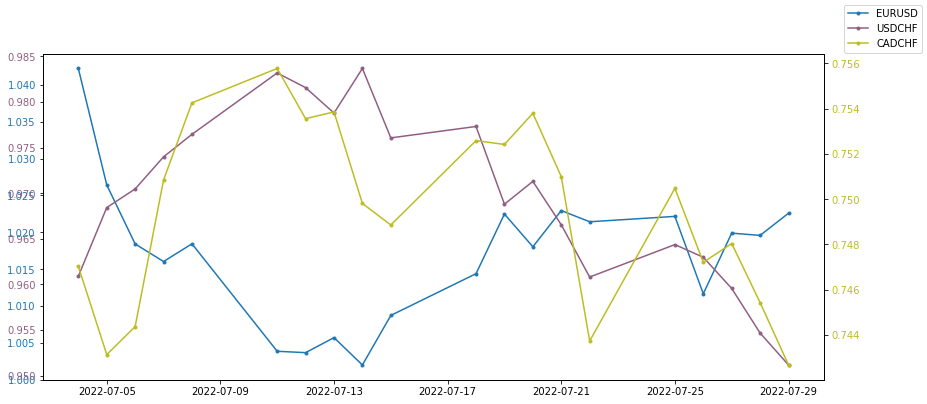

In [18]:
env_instance.render(mode='simple_figure')

## Test

In [19]:
episode_total_assets = DRLAgent_sb3.DRL_prediction_load_from_file(
            model_name=MODEL_NAME, environment=env_instance, cwd=cwd
        )
episode_total_assets

Successfully load model ./ppo
original actions:  [ 0.03996759 -0.00376692 -0.03206335]
self.max_stock:  100.0
self.min_stock_rate:  0.1
actions:  [ 3  0 -3]
min_action:  10
price:  [1.02643 0.96842 0.74313]
np.where(actions < -min_action):  (array([], dtype=int64),)
self.total_asset:  1021825.1557158252
self.stocks:  [52. 55. 42.]
self.stocks * price:  [53.37436  53.2631   31.211462]
(self.stocks * price).sum():  137.84892
total_asset:  1021824.5849913378
reward:  -0.00027867406606674194
self.gamma_reward:  -0.00027867406606674194
original actions:  [ 0.05865217 -0.04320921  0.02121539]
self.max_stock:  100.0
self.min_stock_rate:  0.1
actions:  [ 5 -4  2]
min_action:  10
price:  [1.01842 0.97046 0.74437]
np.where(actions < -min_action):  (array([], dtype=int64),)
self.total_asset:  1021824.5849913378
self.stocks:  [52. 55. 42.]
self.stocks * price:  [52.95784  53.3753   31.263538]
(self.stocks * price).sum():  137.59668
total_asset:  1021824.3327482959
reward:  -0.0001231655478477478
s

[1021825.1557158252,
 1021824.5849913378,
 1021824.3327482959,
 1021824.6747587939,
 1021825.0786284228,
 1021824.7549589892,
 1021824.5633085986,
 1021824.5285338183,
 1021824.4344633837,
 1021824.3254545947,
 1021824.8451689502,
 1021824.7901152392,
 1021824.754684331,
 1021824.6306303759,
 1021823.9310911914,
 1021824.4483488818,
 1021823.689071538,
 1021823.9632719775,
 1021823.5685881396,
 1021823.4166868945]

In [2]:
class Test:
    def __init__(self, name, age):
        self.name = name
        self.age = age

In [3]:
test_1 = Test(name="a", age=10)

In [6]:
test_1.name = 'b'

In [7]:
test_1.name

'b'